# `ModelForge`
### Amortise your Forwards Models

This example is deigned to give a quick overview of how to use `ModelForge` to amortise a forward model.

The main classes we will use are `MLPAmortisedModel`, and `SupervisedAmortiser`

We will use a slightly more complex example, showing how to jointly amortise the recovery of both stellar position (via tip-tilt) and stellar flux. 

As an example we will use the simplest MLP model, with a depth of zero, plus the `ModelForge` `SimpleLinear` layer used as a learning rate filter!

In [1]:
# Packages
import jax
import zodiax as zdx
import equinox as eqx
import dLux as dl
import optax

# Modules
from jax import numpy as np, random as jr, tree_util as jtu
from dLux import layers as dll, utils as dlu
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

# Model Forge
import ModelForge as forge

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

## Make The Forwards Model

In [2]:
# Source parameters
wavelengths = 1e-6 * np.linspace(1., 1.2, 5)
source = dl.PointSource(wavelengths, flux=1e4)

# Wavefront parameters
wf_npix = 256
aper_diam = 2.4

# Generate an aperture manually
coords = dlu.pixel_coords(5*wf_npix, 2.4)
spider_angles = 45 + np.linspace(0, 360, 4, endpoint=False)
outer = dlu.circle(coords, aper_diam/2)
inner = dlu.circle(coords, .3, True)
spiders = dlu.spider(coords, .05, spider_angles)
aperture = dlu.combine([outer, inner, spiders], 5)

# Generate coordinates
coords = dlu.pixel_coords(wf_npix, 2.4)
# zernikes = np.arange(2, 16)
# zernikes = np.arange(2, 10)
zernikes = np.arange(2, 4)
basis = np.array([1e-9 * dlu.zernike(i, coords, aper_diam) for i in zernikes])
coeffs = 2e1 * jr.normal(jr.PRNGKey(0), (len(zernikes),))

# PSF parameters
psf_wf_npix = 64
sampling = 3 # ie 1.5x Nyquist
fringe_size = dlu.fringe_size(wavelengths, aper_diam).min()
psf_pix_scale = 1.22 * dlu.rad2arcsec(fringe_size) / sampling

# Construct optics & Telescope
psf_oversample = 2
layers = [('aperture', dll.BasisOptic(
    aperture, basis, coeffs, normalise=True
))]
optics = dl.AngularOptics(
    wf_npix, aper_diam, layers, psf_wf_npix, psf_pix_scale / psf_oversample
    )
fmodel = dl.Telescope(optics, source)

## Examine

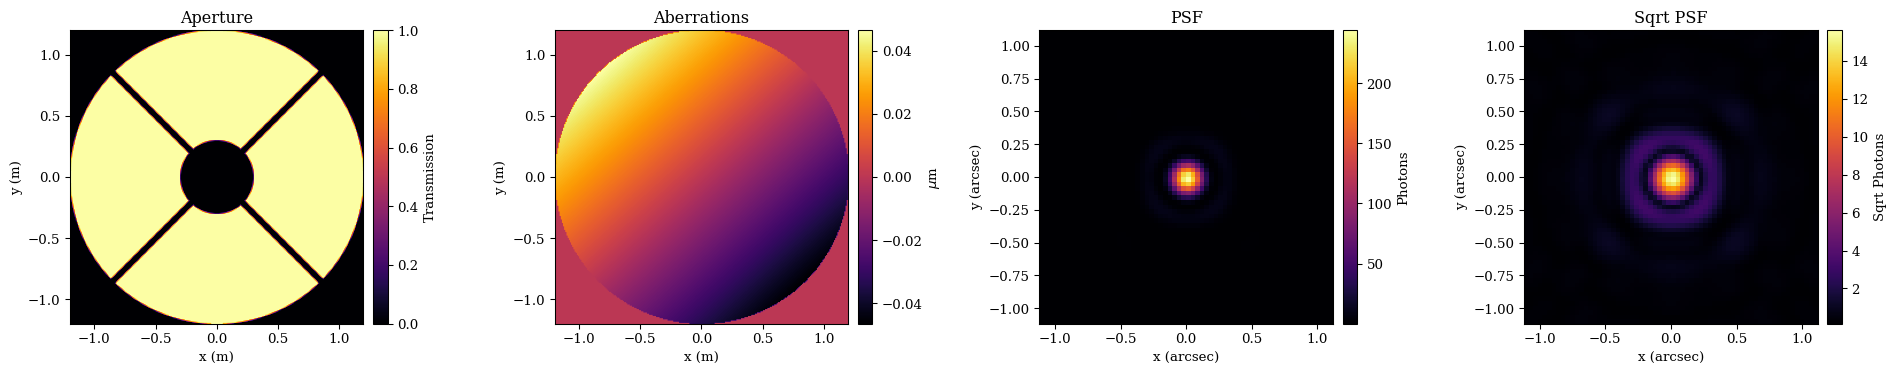

In [3]:
from ModelForge import plotting as p

fig, axes = p.plot_grid_2d(1, 4)

# Aperture plots
r = aper_diam/2
extent = (-r, r, -r, r)

axes[0].set(xlabel='x (m)', ylabel='y (m)', title='Aperture')
im = axes[0].imshow(optics.transmission, extent=extent)
p.add_cbar(fig, axes[0], im, label='Transmission')

axes[1].set(xlabel='x (m)', ylabel='y (m)', title='Aberrations')
im = axes[1].imshow(1e6 * optics.eval_basis(), extent=extent)
p.add_cbar(fig, axes[1], im, label='$\mu$m')

# PSF plots
psf = fmodel.model()
r = psf_pix_scale * psf_wf_npix / 2
extent = (-r, r, -r, r)

axes[2].set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='PSF')
im = axes[2].imshow(psf, extent=extent)
p.add_cbar(fig, axes[2], im, label='Photons')

axes[3].set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='Sqrt PSF')
im = axes[3].imshow(psf**0.5, extent=extent)
p.add_cbar(fig, axes[3], im, label='Sqrt Photons')
fig.tight_layout()

Training Summary:
N Epochs: 100 (total steps)
N Truths: 10 (truth samples per epoch)
N Train:  100 (train samples per epoch)

At each epoch we draw 10 truths and 100 training samples, all of which are vectorised over during the step function.

PSFs per epoch: 1,000
Total PSFs: 100,000

Compiling step function...Done!


Loss:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 	-1.28% avg prediction improvement
Epoch: 10 	-1.83% avg prediction improvement
Epoch: 20 	-0.49% avg prediction improvement
Epoch: 30 	-0.44% avg prediction improvement
Epoch: 40 	-0.02% avg prediction improvement
Epoch: 50 	0.04% avg prediction improvement
Epoch: 60 	0.19% avg prediction improvement
Epoch: 70 	0.03% avg prediction improvement
Epoch: 80 	0.14% avg prediction improvement
Epoch: 90 	0.23% avg prediction improvement
Epoch: 100 	0.17% avg prediction improvement


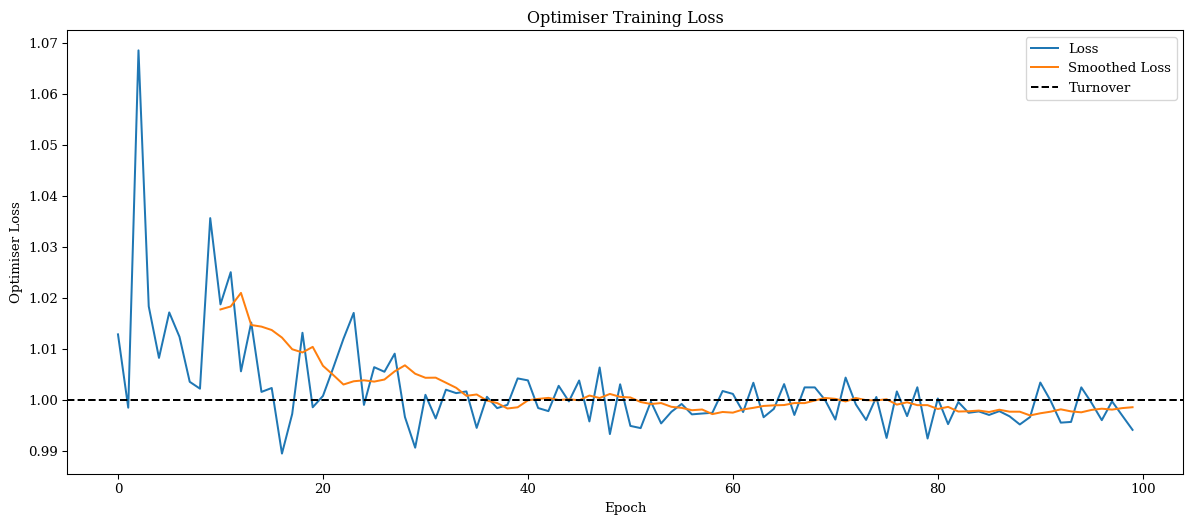

In [5]:
# Step 1: Create the Forward Model
fmodel = dl.Telescope(optics, source)

# Step 2: Create the Joint Model and define distributions
params = ['coefficients', 'flux']
joint_model = forge.MLPAmortisedModel(fmodel, params)

# The 'truths' distributions generate the sample at which we we try to recover the parameters
truths = [
    forge.Normal(mu=0, sigma=1e2, bc_shape=coeffs.shape),
    forge.Uniform(minval=9e3, maxval=11e3)
]

# The 'Samples' distributions generate the samples we try to recover the 'truths' from
samples = [
    forge.Uniform(-200, 200, bc_shape=coeffs.shape),
    forge.Uniform(minval=8e3, maxval=12e3)
]

# Step 3: Create Trainer
optim = optax.adam(1e-2)
trainer = forge.SupervisedAmortiser(joint_model, optim)

# Step 4: Train!
trainer, key = trainer.train_stochastic(truths, samples, epochs=100, n_true=10, n_sample=100, key=jr.PRNGKey(0))
trainer.plot_losses()

# Re-Train!

- Feed in the returned key to get the amortiser to act as if it never stopped training!

- Since these classes are immutable, we can tweak training hyper-parameters between training sessions. 


> The benefit of this construction is we can always tweak the training hyper parameters
> between training runs. So if you try and train on too many PSFs at once and your computer
> begins to brick it, you can just cancel the 

Training Summary:
N Epochs: 400 (total steps)
N Truths: 10 (truth samples per epoch)
N Train:  100 (train samples per epoch)

At each epoch we draw 10 truths and 100 training samples, all of which are vectorised over during the step function.

PSFs per epoch: 1,000
Total PSFs: 400,000

Compiling step function...Done!


Loss:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 0 	0.80% avg prediction improvement
Epoch: 40 	0.32% avg prediction improvement
Epoch: 80 	0.66% avg prediction improvement
Epoch: 120 	0.73% avg prediction improvement
Epoch: 160 	1.20% avg prediction improvement
Epoch: 200 	1.49% avg prediction improvement
Epoch: 240 	1.81% avg prediction improvement
Epoch: 280 	2.41% avg prediction improvement
Epoch: 320 	2.59% avg prediction improvement
Epoch: 360 	2.96% avg prediction improvement
Epoch: 400 	3.29% avg prediction improvement


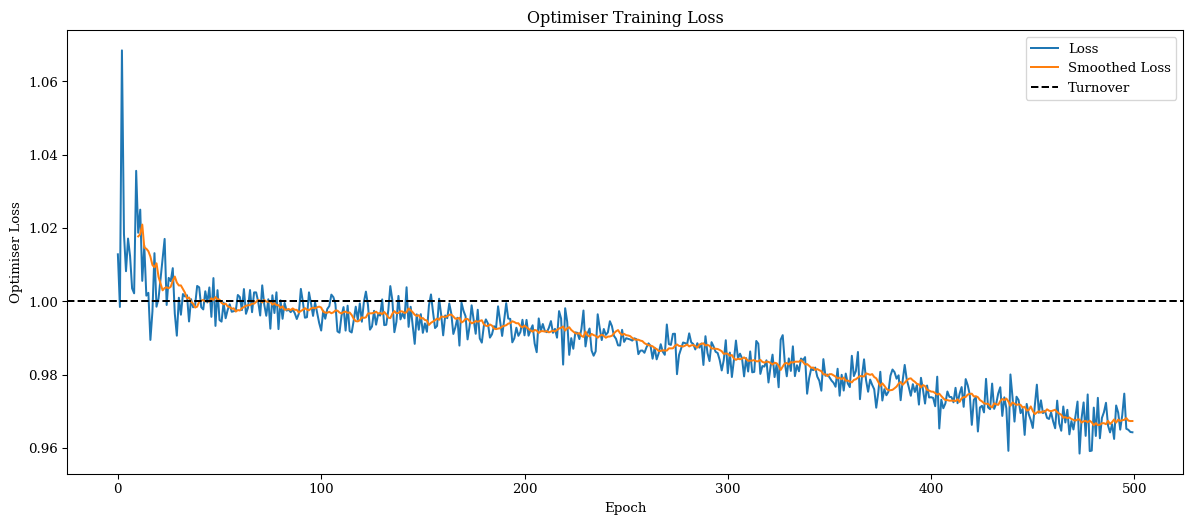

In [8]:
trainer, key = trainer.train_stochastic(truths, samples, epochs=400, n_true=10, n_sample=100, key=key)
trainer.plot_losses()

Awesome, training is slow but as we can see it is learning to predict the PSF from the random samples of the parameters.

# Examine optimiser values

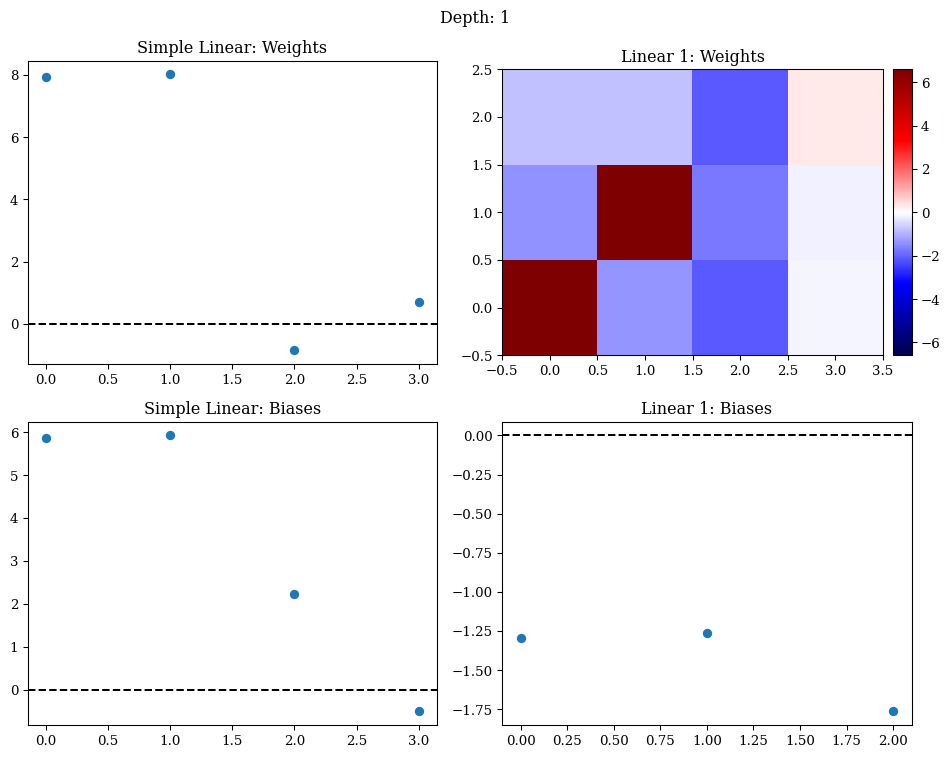

In [10]:
def visualise_optimiser(optimiser):
    from ModelForge import plot_grid_2d, add_cbar

    layers = optimiser.layers
    depth = len(layers)
    
    fig, axes = plot_grid_2d(2, depth, fsx=5, fsy=4)
    fig.suptitle(f"Depth: {depth-1}")

    # First layer is always SimpleLinear
    xs = np.arange(len(layers[0].weight))
    axes[0].set(title="Simple Linear: Weights")
    axes[0].scatter(xs, layers[0].weight)
    axes[0].axhline(0, color='k', linestyle='--')

    axes[depth].set(title="Simple Linear: Biases")
    axes[depth].scatter(xs, layers[0].bias)
    axes[depth].axhline(0, color='k', linestyle='--')

    # All other layers are Linear
    for i in range(1, depth):
        axes[i].set(title=f"Linear {i}: Weights")
        wgt = layers[i].weight
        v = np.max(np.abs(wgt))
        im = axes[i].imshow(layers[i].weight, vmin=-v, vmax=v, cmap='seismic')
        fig = add_cbar(fig, axes[i], im)

    xs = np.arange(len(layers[1].weight))
    for j in range(1, depth):
        i = depth + j
        axes[i].set(title=f"Linear {j}: Biases")
        axes[i].scatter(xs, layers[j].bias)
        axes[i].axhline(0, color='k', linestyle='--')
    fig.tight_layout()

visualise_optimiser(trainer.joint_model.optimiser)